In [ ]:
import os
import string
import glob
from tqdm import tqdm
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3
import tensorflow.keras.preprocessing.image
from tensorflow.keras.models import Sequential
#F-api
from tensorflow.keras.layers import (LSTM, Embedding,
    TimeDistributed, Dense, RepeatVector,
    Activation, Flatten, Reshape, concatenate,
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model
import pandas as pd
import codecs
from gensim.models import KeyedVectors
from gensim.models.fasttext import FastText
from sklearn.decomposition import PCA



from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [ ]:
#START="ابتدا"
#STOP="انتها"

START = "startseq"
STOP = " endseq"


In [ ]:
def hms(sec_elapsed):
    h=int (sec_elapsed/(60*60))
    m=int ((sec_elapsed%(60*60))/60)
    s=sec_elapsed%60
    return f"{h}:{m:>2}:{s:>05.2f}"

In [ ]:
#
#root_captioning="/content/drive/My Drive /Mohasebati"
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False
if COLAB:
    root_captioning="/content/drive/My Drive/Mohasebati"
else:
    root_captioning = "./data/captions"

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
# # txt = "Hello Sam!";
# # mytable = txt.maketrans("S", "P");
# # print(txt.translate(mytable));
# import string
# testCase = ".....ت."
# null_punct = testCase.maketrans('.', ' ',string.punctuation)
# print(testCase)
# print(testCase.translate(null_punct))
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()
with open( os.path.join(root_captioning,'tok2.txt'), 'r') as fp :
    max_length = 0
    for line in fp.read().split('\n'):
        tok = line.split()
        if len(line) >= 2:
            id = tok[0].split('.')[0]
            desc = tok[1:]
            # print("desc normal:", desc)
            # desc = [word.lower() for word in desc]
            # print("desc after lower:", desc)
            desc = [word for word in desc if len(word)>2]
            # print("desc after step-word:", desc)
            desc = [word for word in desc if word.isalpha()]
            #print("desc after isalpha", desc)
            max_length = max(max_length,len(desc))
            #print("max_length", max_length)
            if id not in lookup:
                lookup[id] = list()
                #print("lookup before append:", lookup[id])
            lookup[id].append(' '.join(desc))
            #print("lookup after append:", lookup[id])



lex = set()
for key in lookup:
    # print("LEX BEFORE:", lex)
     [lex.update(d.split()) for d in lookup[key]]
     #print("KEY:", key)
     #print("LEX AFTER:", lex)
    # print("_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_")

# New section

In [ ]:
print(len(lookup))
print(len(lex))
print(max_length)
print(lookup)
#print(len(key))
print(lex)

2526
405
11
{'hodi1': ['هودي سرمه رنگ', 'هودي دور سفيد جيب دار'], 'hodi2': ['هودي ساده زيپ', 'هودي صورتي رنگ کلاه'], 'hodi3': ['هودي بلند زنانه', 'هودي نارنجي ساده کلاه'], 'hodi4': ['هودي زنانه ساده', 'هودي زنانه مشکي کلاه دار'], 'hodi5': ['هودي ساده رنگ', 'هودي ساده برچسب'], 'hodi6': ['هودي طرح دار مردانه', 'هودي برچسب دار سفيد'], 'hodi7': ['هودي زنانه ساده', 'هودي زنانه صورتي رنگ'], 'hodi8': ['هودي زنانه براق', 'هودي زنانه بلند براق ساده'], 'hodi9': ['هودي ساده سبز رنگ', 'هودي طرح ايران ساده زيپ'], 'hodi10': ['هودي ساده دخترانه', 'هودي ساده سفيد برچسب خرگوش'], 'hodi11': ['هودي ساده مردانه', 'هودي ساده برچسب اديداس'], 'hodi12': ['هودي ساده سبز رنگ', 'هودي دخترانه زيپ'], 'hodi13': ['هودي دخترانه ساده', 'هودي صورتي رنگ کلاه دار'], 'hodi14': ['هودي ساده طرح دار', 'هودي طرح تتلو کلاه'], 'hodi15': ['هودي ساده مردانه', 'هودي ساده سفيد ساده'], 'hodi16': ['هودي مشکي زنانه', 'هودي زنانه مشکي کلاه'], 'hodi17': ['هودي ساده کلاه دار', 'هودي طرح بنز ساده'], 'hodi18': ['هودي ساده مشکي', 'هودي استيک

In [ ]:
img=glob.glob(os.path.join(root_captioning,'data','*.jpg'))

In [ ]:
len(img)

2526

In [ ]:
#train_image
train_image_path=os.path.join(root_captioning,'img_train.txt')
train_image=set(open(train_image_path,'r').read().strip().split('\n'))
print(len(train_image))

2349


In [ ]:
#test_image
test_image_path=os.path.join(root_captioning,'img_test.txt')
test_image=set(open(test_image_path,'r').read().strip().split('\n'))
print(len(test_image))

190


In [ ]:
#test_image
train_img = []
test_img = []
recycle_majazi = []
for i in img:
  f = os.path.split(i)[-1]
  # print(f)
  # print(len(f))
  if f in train_image:
    train_img.append(f)
  elif f in test_image:
    test_img.append(f)
  else:
    recycle_majazi.append(f)
#print(recycle_majazi)

In [ ]:
# print(recycle_majazi)
print(len(train_img))
print(len(test_img))
print("---------------------------")
print(len(train_image))
print(len(test_image))

2338
188
---------------------------
2349
190


In [ ]:

train_descriptions={key:value for key,value in lookup.items() if  f'{key}.jpg'in train_image}
print(train_descriptions)
print(len(train_descriptions))
for note,value  in train_descriptions.items():
    for data in range(len(value)):
      value[data]=f'{START} {value[data]}  {STOP}'

{'hodi1': ['startseq هودي سرمه رنگ   endseq', 'startseq هودي دور سفيد جيب دار   endseq'], 'hodi2': ['startseq هودي ساده زيپ   endseq', 'startseq هودي صورتي رنگ کلاه   endseq'], 'hodi3': ['startseq هودي بلند زنانه   endseq', 'startseq هودي نارنجي ساده کلاه   endseq'], 'hodi4': ['startseq هودي زنانه ساده   endseq', 'startseq هودي زنانه مشکي کلاه دار   endseq'], 'hodi5': ['startseq هودي ساده رنگ   endseq', 'startseq هودي ساده برچسب   endseq'], 'hodi6': ['startseq هودي طرح دار مردانه   endseq', 'startseq هودي برچسب دار سفيد   endseq'], 'hodi7': ['startseq هودي زنانه ساده   endseq', 'startseq هودي زنانه صورتي رنگ   endseq'], 'hodi13': ['startseq هودي دخترانه ساده   endseq', 'startseq هودي صورتي رنگ کلاه دار   endseq'], 'hodi14': ['startseq هودي ساده طرح دار   endseq', 'startseq هودي طرح تتلو کلاه   endseq'], 'hodi15': ['startseq هودي ساده مردانه   endseq', 'startseq هودي ساده سفيد ساده   endseq'], 'hodi16': ['startseq هودي مشکي زنانه   endseq', 'startseq هودي زنانه مشکي کلاه   endseq'], 'ho

In [ ]:
len(train_descriptions)

2326

In [ ]:
EPOCHS = 10
USE_INCEPTION = True
if USE_INCEPTION:
  encode_model=InceptionV3(weights='imagenet')
  encode_model=Model(encode_model.input,encode_model.layers[-2].output)
  WIDTH=299
  HEIGHT=299
  OUTPUT_DIM=2048
  preprocess_input = \
    tensorflow.keras.applications.inception_v3.preprocess_input
else :
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
def encodeImage(img):
  img=img.resize((WIDTH,HEIGHT),Image.ANTIALIAS)
  x=tensorflow.keras.preprocessing.image.img_to_array(img)
  x=np.expand_dims(x,axis=0)
  x=preprocess_input(x)
  x=encode_model.predict(x)
  x=np.reshape(x,OUTPUT_DIM)
  return x

In [ ]:
# train_path=os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
# if not os.path.exists(train_path):
#   start=time()
#   encoding_train={}
#   for id in tqdm(train_img):
#     image_path=os.path.join(root_captioning,'Data',id)
#     img=tensorflow.keras.preprocessing.image.load_img(image_path,\
#                                                       target_size=(HEIGHT,WIDTH))
#     encoding_train[id]=encodeImage(img)
#   with open(train_path,"wb") as fp:
#     pickle.dump(encoding_train,fp)
#   print(f"\nGenerating testing set took: {hms(time()-start)}")
# else:
#   with open(test_path,"rb") as fp:
#     encoding_train=pickle.load(fp)



train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'data', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
            target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

100%|██████████| 2338/2338 [19:08<00:00,  2.04it/s]


Generating training set took: 0:19:08.27


In [ ]:

test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'data', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

100%|██████████| 188/188 [01:31<00:00,  2.06it/s]


Generating testing set took: 0: 1:31.48


In [ ]:
all_train_captions=[]
for key ,val in train_descriptions.items():
  for cap in val :
    all_train_captions.append(cap)

print(len(all_train_captions))
print(all_train_captions)

4652
['startseq startseq هودي سرمه رنگ   endseq   endseq', 'startseq startseq هودي دور سفيد جيب دار   endseq   endseq', 'startseq startseq هودي ساده زيپ   endseq   endseq', 'startseq startseq هودي صورتي رنگ کلاه   endseq   endseq', 'startseq startseq هودي بلند زنانه   endseq   endseq', 'startseq startseq هودي نارنجي ساده کلاه   endseq   endseq', 'startseq startseq هودي زنانه ساده   endseq   endseq', 'startseq startseq هودي زنانه مشکي کلاه دار   endseq   endseq', 'startseq startseq هودي ساده رنگ   endseq   endseq', 'startseq startseq هودي ساده برچسب   endseq   endseq', 'startseq startseq هودي طرح دار مردانه   endseq   endseq', 'startseq startseq هودي برچسب دار سفيد   endseq   endseq', 'startseq startseq هودي زنانه ساده   endseq   endseq', 'startseq startseq هودي زنانه صورتي رنگ   endseq   endseq', 'startseq startseq هودي دخترانه ساده   endseq   endseq', 'startseq startseq هودي صورتي رنگ کلاه دار   endseq   endseq', 'startseq startseq هودي ساده طرح دار   endseq   endseq', 'startseq start

In [ ]:
word_count_threshold=10
word_counts={}
# ix=1
# for w in vocab:
#   wordtoidx=ix
#   idxtoword[ix]=w
#   ix+=1


# vocab_size=len(idxtoword)+
# vocab_size
nsents=0
for sent in all_train_captions:
  nsents+=1

  for w in sent.split(' '):
    word_counts[w]=word_counts.get(w,0)+1



vocab=[w for w in word_counts if word_counts[w]>=word_count_threshold ]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))
print("------------------------------------------------------------")
print(word_counts)
print('#################################################################')
print(nsents)
print("________________________________________________________________")


preprocessed words 387 ==> 74
------------------------------------------------------------
{'startseq': 9304, 'هودي': 194, 'سرمه': 110, 'رنگ': 1713, '': 18609, 'endseq': 9304, 'دور': 1, 'سفيد': 19, 'جيب': 6, 'دار': 289, 'ساده': 867, 'زيپ': 5, 'صورتي': 9, 'کلاه': 65, 'بلند': 328, 'زنانه': 1186, 'نارنجي': 2, 'مشکي': 120, 'برچسب': 35, 'طرح': 266, 'مردانه': 1487, 'دخترانه': 1, 'تتلو': 3, 'بنز': 1, 'استيکر': 1, 'اديداس': 1, 'توسي': 25, 'خرگوش': 2, 'سبز': 103, 'آبي': 3, 'متن': 4, 'هيچ': 1, 'آستين': 2, 'ورزشي': 10, 'استين': 1, 'کوتاه': 66, 'اکون': 1, 'قهوه': 64, 'جوکر': 1, 'زاپ': 1, 'زرشکي': 2, 'بازو': 2, 'براق': 15, 'پشمي': 1, 'جديد': 1, 'مدرن': 4, 'جيتيآي': 1, 'چشم': 1, 'سيسپک': 1, 'ايران': 1, 'زرد': 74, 'کرم': 120, 'گنجشک': 1, 'خرس': 1, 'قرمز': 137, 'بنفش': 22, 'پرسپوليس': 1, 'اسب': 1, 'حرف': 1, 'فارسي': 1, 'ايکس': 1, 'دختر': 1, 'مرادانه': 1, 'شارپ': 1, 'ستاره': 1, 'فيلا': 1, 'نايک': 1, 'يوونتوس': 1, 'هودی': 268, 'گلمبی': 28, 'آبی': 158, 'دورنگ': 2, 'میکی': 1, 'موس': 1, 'شبرنگ': 1, 'چند': 

In [ ]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1

vocab_size = len(idxtoword) + 1
vocab_size

75

In [ ]:

max_length +=2
print(max_length)

13


In [ ]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 -  caption that  photo
  # y - The predicted caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      #2bar
      for desc in desc_list:

        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]

        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          #tf.keras.preprocessing.sequence.pad_sequences(
   # sequences, maxlen=None, dtype="int32", padding="pre", truncating="pre", value=0.0
#)
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [ ]:
sentence=open('/content/drive/My Drive/Mohasebati/glove/1.txt',mode='r',encoding='utf-8')
new_lines=[]
for line in sentence:
  new_lines.append(line.split())


print(len(new_lines))

5052


In [ ]:
corpus=[]
with codecs.open("1.txt","r","utf-8")as t:
  for sentence in t:
    word_list=[word for word in sentence.split()]
    corpus.append(word_list)


embedding_size=30
window_size=30
min_word=10
down_sampling=1000
model=FastText(corpus,
               size=embedding_size,
               window=window_size,
               min_count=min_word,
               sample=down_sampling,
               sg=1,
               iter=10
                      )

words=list(model.wv.vocab)

In [ ]:
model.save("FastText.model")

In [ ]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)

result = pca.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


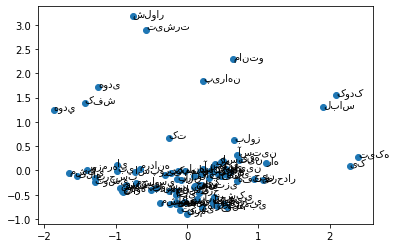

In [ ]:
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

  Created wheel for arabic-reshaper: filename=arabic_reshaper-2.1.1-cp36-none-any.whl size=16504 sha256=f6fe79fe2d67bc9dcdba5bc6df51c6f087afbdc36f397ed8c3760fd436d5193e
  Stored in directory: /root/.cache/pip/wheels/62/52/d8/bd0dcbf00f9e77e3bd0184285ed77dfa9c475dac494a5353d1
Successfully built arabic-reshaper


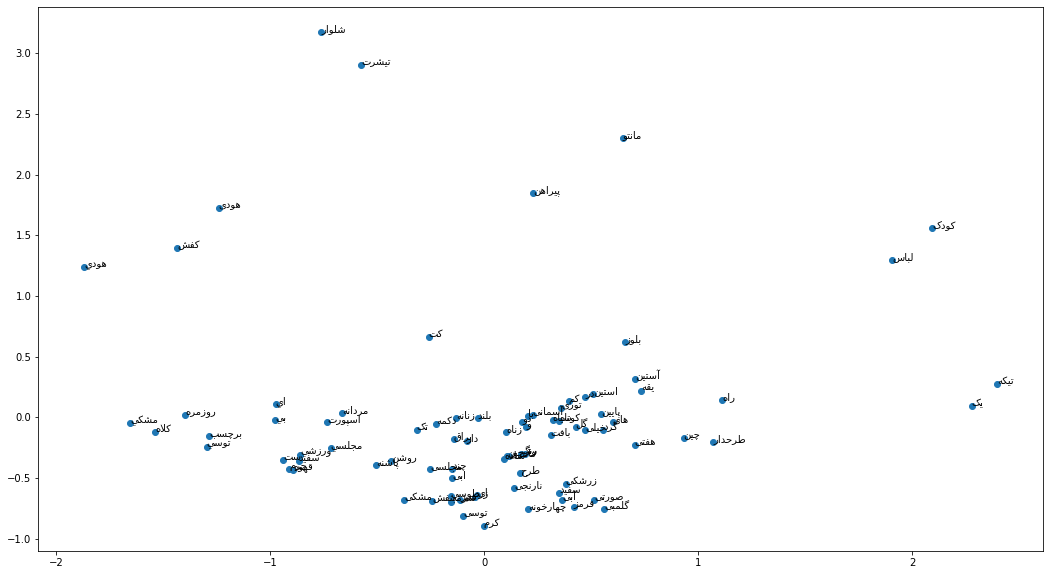

In [ ]:
!pip install arabic_reshaper
!pip install python-bidi
import arabic_reshaper
from bidi.algorithm import get_display
size = 100
plt.figure(figsize=(18, 10))
plt.scatter(result[:, 0][:size], result[:, 1][:size])
words = list(model.wv.vocab)
for i, word in enumerate(words[:size]):
    word = get_display(arabic_reshaper.reshape(word))
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))



In [ ]:
 embedding_dim =5
 embedding_matrix = np.zeros((vocab_size, embedding_dim))
 for word, i in wordtoidx.items():
    if i < max_words:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector



ValueError: ignored

In [ ]:
!pip install persian_wordcloud

     |████████████████████████████████| 71kB 3.6MB/s 
  Created wheel for persian-wordcloud: filename=persian_wordcloud-1.3.1-cp36-none-any.whl size=65942 sha256=e8f26d87908aada034f75ae5cc3dce265ad24c09364b94a7eb310d3cfef804cb
  Stored in directory: /root/.cache/pip/wheels/d6/cb/3e/9cbd2b569d53b1442208fa3a4c66c2fc2bd6ade54231d08549
Successfully built persian-wordcloud


In [ ]:
from os import path
import persian_wordcloud
from persian_wordcloud.wordcloud import PersianWordCloud, add_stop_words
import wordcloud
from wordcloud import STOPWORDS as EN_STOPWORDS
import glob
import re
folder_path="1.txt"

In [ ]:
def removeWeirdChars(text):
    weridPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    return weridPatterns.sub(r'', text)

In [ ]:

for file_name in glob.glob(folder_path): # folder containing the text files
    text_f = open(file_name, "r", encoding='utf-8')
    text=text_f.read()
    text = removeWeirdChars(text)
    print(text)


    # Add another stopword
    stopwords = add_stop_words(['<number>','<url>', '<hashtag>','</hashtag>'])

هودي سرمه اي رنگ
هودي دور سفيد جيب دار
هودي ساده بي زيپ.
هودي صورتي رنگ بي کلاه
هودي بلند زنانه
هودي نارنجي ساده بي کلاه
هودي زنانه ساده
هودي زنانه مشکي  کلاه دار
هودي ساده در دو رنگ
هودي ساده برچسب.
هودي طرح دار  مردانه
هودي برچسب دار سفيد
هودي زنانه ساده
هودي زنانه صورتي رنگ
هودي زنانه براق
هودي زنانه بلند براق ساده
هودي ساده سبز رنگ
هودي طرح ايران ساده  بي زيپ
هودي ساده دخترانه
هودي ساده سفيد با برچسب خرگوش
هودي ساده مردانه
هودي ساده برچسب اديداس
هودي ساده سبز کم رنگ
هودي دخترانه  بي زيپ
هودي دخترانه ساده
هودي صورتي رنگ کلاه دار
هودي ساده طرح دار
هودي طرح تتلو  بي کلاه
هودي ساده مردانه
هودي ساده سفيد ساده
هودي مشکي زنانه
هودي زنانه مشکي بي کلاه
هودي ساده کلاه دار
هودي طرح بنز ساده
هودي ساده مشکي
هودي استيکر دار بي کلاه
هودي ساده زنانه
هودي صورتي رنگ برچسب اديداس
هودي ساده توسي
هودي بي کلاه مردانه ساده
هودي طرح دار زنانه
هودي طرح خرگوش سفيد رنگ
هودي ساده ست
هودي مشکي ست
هودي ساده سبز
هودي ساده سبز رنگ بي کلاه
هودي مشکي ساده
هودي مشکي طرح دار کلاه دار
هودي ساده زيپ دار
هودي ساده بي کل

In [ ]:
 wordcloud = PersianWordCloud(
        only_persian=True,
        max_words=20,
        stopwords=stopwords,
        margin=0,
        width=800,
        height=800,
        min_font_size=1,
        max_font_size=500,
        background_color="white").generate(str(text))

In [ ]:
image = wordcloud.to_image()
image.save("1.png")

In [ ]:
# # # # import zipfile

# # # # !files -xf cc.fa.300.vec.gz
# # # # with zipfile.ZipFile(files,'r')as z:
# # # #   z.extractall()
# # # # # import zipfile
# # # # # with zipfile.ZipFile(files,'r')as z:
# # # # #   z.extractall()
# # # import tarfile

# # # tar = tarfile.open("")
# # # !tar xvzf cc.fa.300.vec.gz
# # import lzma

# # with lzma.open("/content/drive/My Drive/Mohasebati/FastText/cc.fa.300.vec.gz") as f:
# #     file_content = f.read()
# # with lzma.open("/content/drive/My Drive/Mohasebati/FastText/cc.fa.300.vec.gz") as f, open('extracted', 'wb') as fout:
# #     file_content = f.read()
# #     fout.write(file_content)
# !pip install pyunpack
# !pip install patool

# from pyunpack import Archive
# Archive('/content/drive/My Drive/Mohasebati/FastText/cc.fa.300.vec.gz').extractall('/content/drive/My Drive/Mohasebati/FastText')
# !tar -xvf cc.fa.300.vec.gz
files="/content/drive/My Drive/Mohasebati/FastText/cc.fa.300.vec.gz"
!tar --gunzip --extract --verbose --file="/content/drive/My Drive/Mohasebati/FastText/cc.fa.300.vec.gz"

tar: This does not look like a tar archive
tar: Skipping to next header
tar: Exiting with failure status due to previous errors


In [ ]:
#model1=model = KeyedVectors.load_word2vec_format(r'Z:\word_Emb\cc.fa.300.vec',
                #                          limit = 50000)




fasttext_dir=os.path.join(root_captioning,'FastText')
embeddings_index = {}
f = open(os.path.join(fasttext_dir, 'cc.fa.300.vec'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')


2000001it [02:58, 11213.55it/s]

Found 2000000 word vectors.


In [ ]:
# !pip install smart_open
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# # Work around misordering of STREAM and STDIN in Jupyter.
# # https://github.com/jupyter/notebook/issues/3159
# prompt = !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass(prompt[0] + '\n\nEnter verification code: ')
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# !mkdir -p drive
# !google-drive-ocamlfuse drive

# print ('Files in Drive:')
# !ls drive/

# # Create a file in Drive.
# !echo "This newly created file will appear in your Drive file list." > drive/created.txt
embedding_dim = 300

#numpy.zeros(shape, dtype=float, order='C')
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(75, 300)

In [ ]:
inputs1 = Input(shape=(OUTPUT_DIM,))
#tf.keras.Input #   shape=None, batch_size=None, name=None, dtype=None, sparse=False, tensor=None#   ragged=False, **kwargs)
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

300


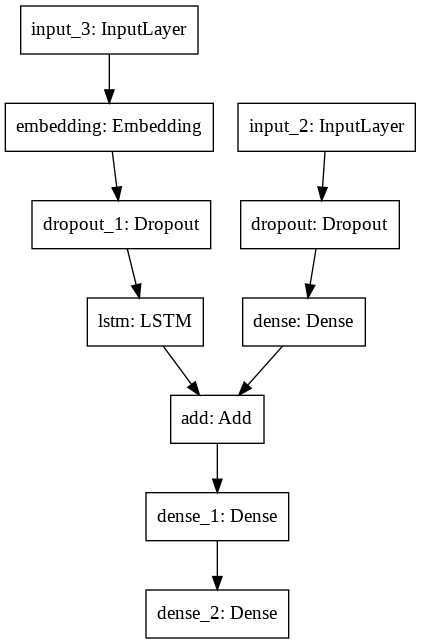

In [ ]:
print(embedding_dim)
from keras.utils import plot_model
plot_model(caption_model,to_file='fun-api.png')

In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 300)      22500       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:

caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
start = time()
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train,
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1,
                    steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train,
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1,
                            steps_per_epoch=steps, verbose=1)
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms(time()-start)}")
else:
  caption_model.load_weights(model_path)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


775/775 [==============================] - 81s 99ms/step - loss: 1.3755


  5%|▌         | 1/20 [01:20<25:33, 80.71s/it]

775/775 [==============================] - 77s 99ms/step - loss: 0.5804


 10%|█         | 2/20 [02:37<23:52, 79.59s/it]

775/775 [==============================] - 76s 98ms/step - loss: 0.5322


 15%|█▌        | 3/20 [03:54<22:16, 78.62s/it]

775/775 [==============================] - 77s 99ms/step - loss: 0.5243


 20%|██        | 4/20 [05:10<20:48, 78.04s/it]

775/775 [==============================] - 77s 99ms/step - loss: 0.4958


 25%|██▌       | 5/20 [06:27<19:24, 77.63s/it]

775/775 [==============================] - 77s 99ms/step - loss: 0.4750


 30%|███       | 6/20 [07:44<18:03, 77.40s/it]

775/775 [==============================] - 76s 98ms/step - loss: 0.4815


 35%|███▌      | 7/20 [09:00<16:41, 77.02s/it]

775/775 [==============================] - 76s 98ms/step - loss: 0.4547


 40%|████      | 8/20 [10:16<15:21, 76.75s/it]

775/775 [==============================] - 76s 98ms/step - loss: 0.4394


 45%|████▌     | 9/20 [11:32<14:03, 76.64s/it]

775/775 [==============================] - 76s 98ms/step - loss: 0.4398


 50%|█████     | 10/20 [12:49<12:45, 76.52s/it]

775/775 [==============================] - 76s 98ms/step - loss: 0.4194


 55%|█████▌    | 11/20 [14:05<11:28, 76.48s/it]

775/775 [==============================] - 76s 98ms/step - loss: 0.4219


 60%|██████    | 12/20 [15:21<10:11, 76.43s/it]

775/775 [==============================] - 76s 98ms/step - loss: 0.4215


 65%|██████▌   | 13/20 [16:38<08:54, 76.37s/it]

775/775 [==============================] - 76s 98ms/step - loss: 0.4147


 70%|███████   | 14/20 [17:53<07:37, 76.17s/it]

775/775 [==============================] - 76s 98ms/step - loss: 0.4081


 75%|███████▌  | 15/20 [19:09<06:20, 76.03s/it]

775/775 [==============================] - 76s 98ms/step - loss: 0.3964


 80%|████████  | 16/20 [20:25<05:04, 76.07s/it]

775/775 [==============================] - 77s 99ms/step - loss: 0.4057


 85%|████████▌ | 17/20 [21:42<03:48, 76.25s/it]

775/775 [==============================] - 77s 99ms/step - loss: 0.4080


 90%|█████████ | 18/20 [22:59<02:32, 76.47s/it]

775/775 [==============================] - 76s 98ms/step - loss: 0.4035


 95%|█████████▌| 19/20 [24:15<01:16, 76.30s/it]

775/775 [==============================] - 77s 99ms/step - loss: 0.4088


100%|██████████| 20/20 [25:31<00:00, 76.59s/it]


387/387 [==============================] - 58s 150ms/step - loss: 0.4813
\Training took: 0:35:10.35


In [ ]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

/content/drive/My Drive/Mohasebati/data/hodi147.jpg


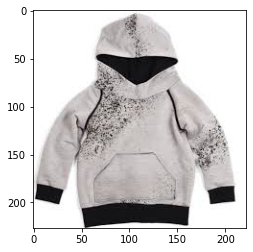

Caption: تیشرت
_____________________________________
/content/drive/My Drive/Mohasebati/data/hodi234.jpg


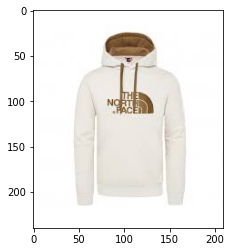

Caption: پیراهن مردانه آستین
_____________________________________
/content/drive/My Drive/Mohasebati/data/hodi87.jpg


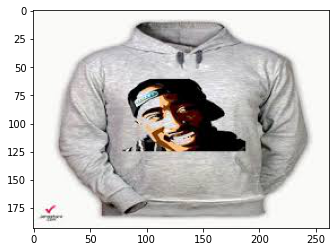

Caption: هودی مردانه
_____________________________________
/content/drive/My Drive/Mohasebati/data/manto50.jpg


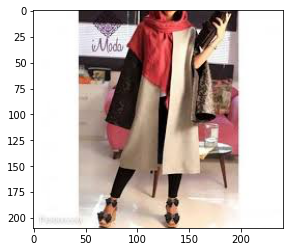

Caption: مانتو
_____________________________________
/content/drive/My Drive/Mohasebati/data/manto142.jpg


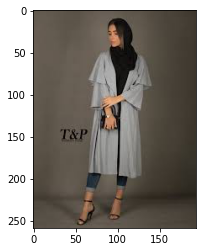

Caption: مانتو
_____________________________________
/content/drive/My Drive/Mohasebati/data/bloze211.jpg


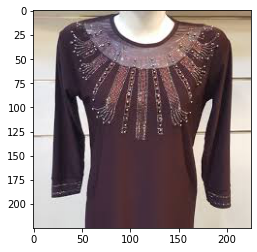

Caption: تیشرت
_____________________________________
/content/drive/My Drive/Mohasebati/data/bloze151.jpg


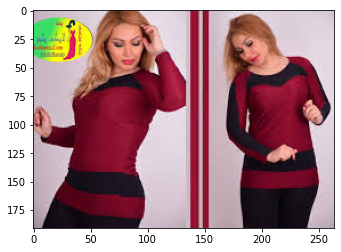

Caption: تیشرت
_____________________________________
/content/drive/My Drive/Mohasebati/data/bloze9.jpg


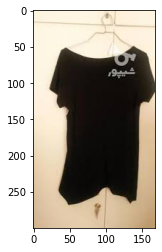

Caption: تیشرت
_____________________________________
/content/drive/My Drive/Mohasebati/data/kafsheF49.jpg


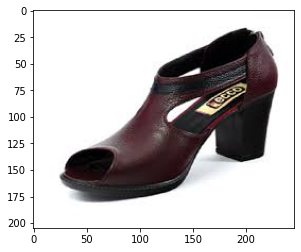

Caption: کفش زنانه
_____________________________________
/content/drive/My Drive/Mohasebati/data/shalvarF8.jpg


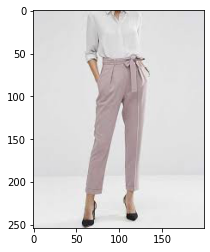

Caption: شلوار
_____________________________________


In [ ]:

for z in range(100,150,5): # set higher to see more examples
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'data', pic))
  x=plt.imread(os.path.join(root_captioning,'data', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

/content/drive/My Drive/Mohasebati/data/tshirtF22.jpg


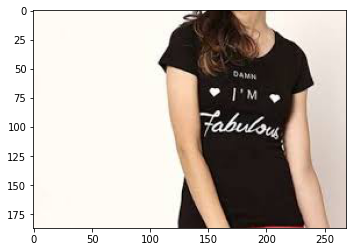

Caption: startseq تیشرت
_____________________________________
/content/drive/My Drive/Mohasebati/data/tshirtF91.jpg


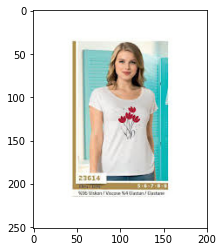

Caption: startseq تیشرت
_____________________________________
/content/drive/My Drive/Mohasebati/data/tshirtF246.jpg


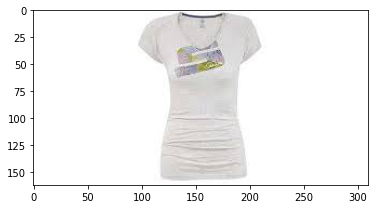

Caption: startseq تیشرت
_____________________________________
/content/drive/My Drive/Mohasebati/data/koodak238.jpg


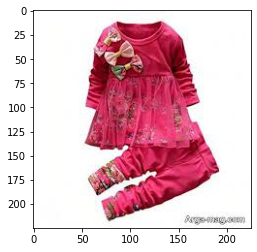

Caption: startseq تیشرت
_____________________________________
/content/drive/My Drive/Mohasebati/data/bloze207.jpg


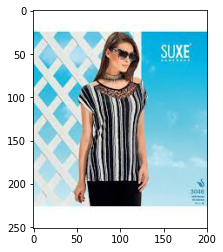

Caption: startseq تیشرت
_____________________________________
/content/drive/My Drive/Mohasebati/data/coat102.jpg


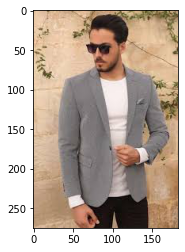

Caption: startseq مردانه
_____________________________________
/content/drive/My Drive/Mohasebati/data/bloze245.jpg


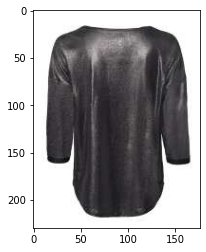

Caption: startseq تیشرت
_____________________________________
/content/drive/My Drive/Mohasebati/data/shalvar104.jpg


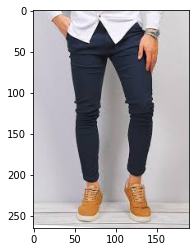

Caption: startseq شلوار
_____________________________________
/content/drive/My Drive/Mohasebati/data/kafshe37.jpg


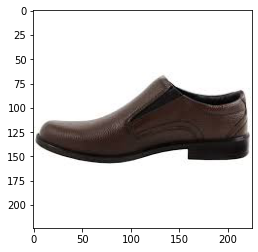

Caption: startseq کفش زنانه
_____________________________________
/content/drive/My Drive/Mohasebati/data/hodi147.jpg


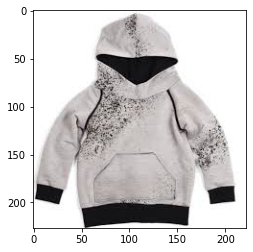

Caption: startseq تیشرت
_____________________________________
/content/drive/My Drive/Mohasebati/data/hodi87.jpg


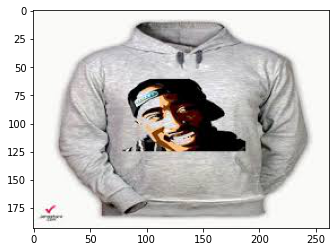

Caption: startseq هودی مردانه طرح
_____________________________________
/content/drive/My Drive/Mohasebati/data/manto142.jpg


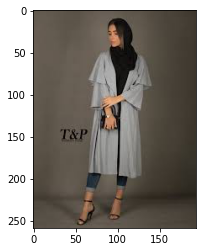

Caption: startseq مانتو
_____________________________________
/content/drive/My Drive/Mohasebati/data/bloze151.jpg


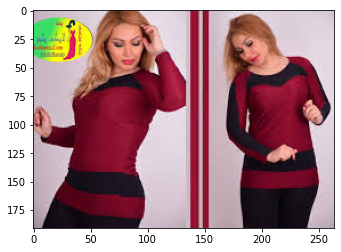

Caption: startseq تیشرت
_____________________________________
/content/drive/My Drive/Mohasebati/data/kafsheF49.jpg


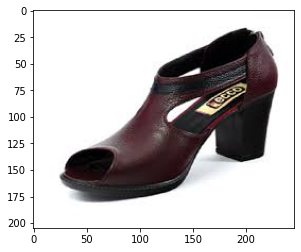

Caption: startseq کفش زنانه
_____________________________________


In [ ]:

for z in range(10,150,10): # set higher to see more examples
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'data', pic))
  x=plt.imread(os.path.join(root_captioning,'data', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")